# Trader Behavior vs Market Sentiment

This project analyzes the relationship between trader behavior and market sentiment using real trading data and the Bitcoin Fear & Greed Index. The goal is to uncover insights that can support smarter, sentiment-driven trading strategies.


## Step 1: Load and explore the Data

In [68]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
import pandas as pd

# Set the project path (change folder name if needed)
project_path = '/content/drive/MyDrive/ds_ankurjat'

# Now set the CSV path
csv_path1 = f'{project_path}/csv_files/fear_greed_index.csv'
csv_path2 = f'{project_path}/csv_files/historical_data.csv'

sentiment_df = pd.read_csv(csv_path1)
trader_df = pd.read_csv(csv_path2)

In [70]:
sentiment_df.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


- The dataset contains daily records of market sentiment.

- classification tells us whether the market was in Fear or Extreme Fear (or later also "Greed").

- The date column is in readable format, while timestamp is in Unix format.

In [71]:
trader_df.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


## Trade Data Overview

Each row in the dataset represents an individual trade, and includes the following key details:

- **Execution Price**: The price at which the trade was executed.
- **Size USD**: The total value of the trade in USD.
- **Side (BUY/SELL)**: Indicates whether the trade was a purchase (BUY) or a sale (SELL).

Additional information includes:

- **Timestamp IST**: The date and time the trade occurred, in `DD-MM-YYYY HH:MM` format.
  - This will be used to **join with sentiment data**.
  - We need to **convert it to a `datetime` object** and extract the **date** for analysis.

Other useful fields:

- **Closed PnL**: The profit or loss realized when the trade is closed.
- **Fee**: The transaction cost incurred.
- **Start Position**: The position value at the start of the trade.

These features together help in analyzing trade performance and market behavior over time.


## Step 2: Import Libreries

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Step 3: Data Cleaning and Date Conversion

To align both datasets by date, we will:
1. Convert the `date` column in the sentiment data to `datetime` format.
2. Convert `Timestamp IST` from trader data to `datetime` and extract the date.
This allows us to later merge both datasets on the same date format.


In [73]:
# STEP 3: Convert date columns to datetime format

# Convert 'date' in sentiment_df
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'], format='%Y-%m-%d')

# Convert 'Timestamp IST' in trader_df
trader_df['Timestamp IST'] = pd.to_datetime(trader_df['Timestamp IST'], format='%d-%m-%Y %H:%M')

# Create a new 'date' column from the timestamp
trader_df['date'] = trader_df['Timestamp IST'].dt.date

# Confirm the conversion
sentiment_df['date'].head(), trader_df['date'].head()


(0   2018-02-01
 1   2018-02-02
 2   2018-02-03
 3   2018-02-04
 4   2018-02-05
 Name: date, dtype: datetime64[ns],
 0    2024-12-02
 1    2024-12-02
 2    2024-12-02
 3    2024-12-02
 4    2024-12-02
 Name: date, dtype: object)

The `date` column in the sentiment data is now in `datetime64` format, and the `Timestamp IST` column in the trader data has been correctly converted to `date` objects. This ensures both datasets are ready to be merged based on matching dates.


## Step 4: Checking for Missing Values

Before proceeding with any data merging, it's essential to identify and handle missing values. We check both datasets for null entries that could affect our analysis or joins.


In [74]:
# Check in sentiment dataset
print("Missing Values in Sentiment Dataset:")
print(sentiment_df.isnull().sum())

# Check in trader dataset
print("\n Missing Values in Trader Dataset:")
print(trader_df.isnull().sum())


Missing Values in Sentiment Dataset:
timestamp         0
value             0
classification    0
date              0
dtype: int64

 Missing Values in Trader Dataset:
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
date                0
dtype: int64


The missing value check shows that both `sentiment_df` and `trader_df` contain no null or missing values across any of their columns. This ensures we can proceed safely with filtering and merging without the need for imputation or row removal.


## Step 5: Filter Sentiment Data to Match Trader Dates

Since the trader data only includes recent dates (mostly from 2024), we filter the sentiment dataset to only keep rows that fall within the date range of the trader data. This prepares both datasets for a clean merge on the `date` column.


In [75]:
# Find min and max date from trader data
min_date = trader_df['date'].min()
max_date = trader_df['date'].max()

# Filter sentiment data between those dates
filtered_sentiment = sentiment_df[(sentiment_df['date'] >= pd.to_datetime(min_date)) &
                                  (sentiment_df['date'] <= pd.to_datetime(max_date))]

# Show the first few rows to verify
print("Filtered Sentiment Data:")
filtered_sentiment.head()


Filtered Sentiment Data:


,timestamp,value,classification,date
1912,1682919000,63,Greed,2023-05-01
1913,1683005400,55,Greed,2023-05-02
1914,1683091800,64,Greed,2023-05-03
1915,1683178200,64,Greed,2023-05-04
1916,1683264600,61,Greed,2023-05-05


After filtering, the sentiment dataset now includes only records from May 2023 onward, aligning with the date range of the trader dataset. This ensures the two datasets can be accurately merged on the `date` column.


## Step 6: Merge Trader and Sentiment Datasets

Now that both datasets have a common `date` column and matching date ranges, we merge them using an inner join. This gives us a unified view combining each trader's activity with the corresponding market sentiment classification.


In [76]:
# Convert both date columns to datetime format
trader_df['date'] = pd.to_datetime(trader_df['date'])
filtered_sentiment['date'] = pd.to_datetime(filtered_sentiment['date'])

# Now merge
merged_df = pd.merge(trader_df, filtered_sentiment, on='date', how='inner')

# Display shape and sample
print(" Merged DataFrame Shape:", merged_df.shape)
merged_df.head()


 Merged DataFrame Shape: (211218, 20)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,date,timestamp,value,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-12-02 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02,1733117400,80,Extreme Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-12-02 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02,1733117400,80,Extreme Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-12-02 22:50:00,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02,1733117400,80,Extreme Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-12-02 22:50:00,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02,1733117400,80,Extreme Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-12-02 22:50:00,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02,1733117400,80,Extreme Greed


The merge was successful, producing 211,218 rows where each trade is now aligned with the corresponding market sentiment on that date. We can now analyze trader behavior (e.g., PnL, leverage, size) under different sentiment classifications like "Fear", "Greed", and "Extreme Greed".


## Step 7: Summary Statistics by Market Sentiment

To understand how trader behavior changes with sentiment, we analyze:
- **Profitability** using `Closed PnL`
- **Volume** using `Size USD`
- **Risk** using `Fee`

We group trades by `classification` (e.g., Fear, Greed, Extreme Greed) and compute the average or total values for these metrics.


In [77]:
# Group data by sentiment classification and summarize trading behavior

# Average Closed PnL (Profitability)
avg_pnl = merged_df.groupby('classification')['Closed PnL'].mean()

# Total trade volume in USD (Volume)
total_volume = merged_df.groupby('classification')['Size USD'].sum()

# Average fee paid (Risk indicator)
avg_fee = merged_df.groupby('classification')['Fee'].mean()

# Display results
print(" Average Closed PnL (Profitability):\n", avg_pnl)
print("\n Total Trade Volume (USD):\n", total_volume)
print("\n Average Fee Paid (Risk):\n", avg_fee)


 Average Closed PnL (Profitability):
 classification
Extreme Fear     34.537862
Extreme Greed    67.892861
Fear             54.290400
Greed            42.743559
Neutral          34.307718
Name: Closed PnL, dtype: float64

 Total Trade Volume (USD):
 classification
Extreme Fear     1.144843e+08
Extreme Greed    1.244652e+08
Fear             4.833248e+08
Greed            2.885825e+08
Neutral          1.802421e+08
Name: Size USD, dtype: float64

 Average Fee Paid (Risk):
 classification
Extreme Fear     1.116291
Extreme Greed    0.675902
Fear             1.495172
Greed            1.254372
Neutral          1.044798
Name: Fee, dtype: float64


### Summary Insight: Trader Behavior by Market Sentiment

- **Profitability** (`Closed PnL`) is highest during **Extreme Greed** (≈ 67.89), followed by **Fear** (≈ 54.29).
- **Total Volume** is significantly higher during **Fear** (≈ 483M USD), suggesting more trades or larger trades happen when fear dominates.
- **Risk (Fees Paid)** is highest in **Fear** (≈ 1.50), indicating traders may be taking riskier or more frequent actions under fearful conditions.

This suggests that while traders profit more during "greedy" sentiment, they are **most active and pay more fees during fear**, potentially reacting to uncertainty or volatility.


## Step 8: Visualizing Key Metrics by Sentiment

To better understand how trading behavior varies with market sentiment, we use bar plots to visualize:
- **Average Profitability** (Closed PnL)
- **Total Trade Volume** (Size USD)
- **Average Fees Paid**

These visualizations reveal which sentiments are associated with more profitable or riskier trades.


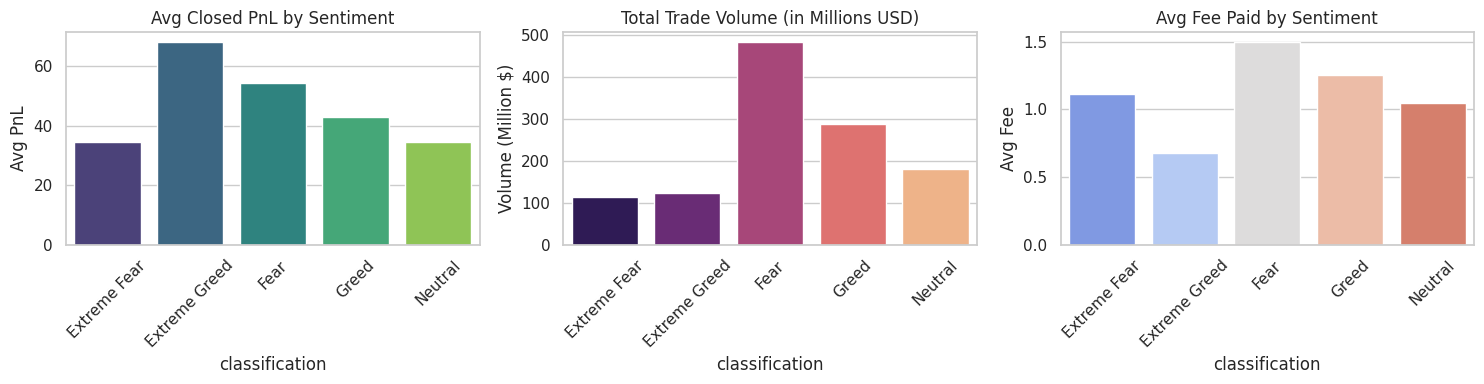

In [78]:
# Set the visual style
sns.set(style="whitegrid")
plt.figure(figsize=(15, 4))

# --- Subplot 1: Avg PnL ---
plt.subplot(1, 3, 1)
sns.barplot(x=avg_pnl.index, y=avg_pnl.values, palette="viridis")
plt.title("Avg Closed PnL by Sentiment")
plt.ylabel("Avg PnL")
plt.xticks(rotation=45)

# --- Subplot 2: Total Volume ---
plt.subplot(1, 3, 2)
sns.barplot(x=total_volume.index, y=total_volume.values / 1e6, palette="magma")
plt.title("Total Trade Volume (in Millions USD)")
plt.ylabel("Volume (Million $)")
plt.xticks(rotation=45)

# --- Subplot 3: Avg Fee ---
plt.subplot(1, 3, 3)
sns.barplot(x=avg_fee.index, y=avg_fee.values, palette="coolwarm")
plt.title("Avg Fee Paid by Sentiment")
plt.ylabel("Avg Fee")
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/ds_ankurjat/outputs/sentiment_metrics_barplot.png")
plt.show()

###  Insight Summary: Key Metrics by Sentiment (Bar Plots)

- **Profitability**: Traders earned the highest average `Closed PnL` during **Extreme Greed**, suggesting high confidence leads to better outcomes.
- **Volume**: Surprisingly, total trade volume peaked during **Fear**, indicating increased activity, possibly due to market panic or volatility.
- **Fees (Risk)**: The highest average fees were also seen during **Fear**, suggesting more aggressive or frequent trading behavior under stress.

These trends indicate that although "Greed" offers better profit opportunities, "Fear" drives more trades with potentially riskier strategies — a valuable insight for building smarter trading algorithms.


## Step 9: Distribution of Closed PnL by Sentiment (Boxplot)

While average PnL gives a general idea of profitability, it doesn’t show how consistent or volatile profits are. Using a boxplot, we can observe:
- Median profit per sentiment
- Spread and variability (risk)
- Presence of outliers (extremely high/low profits)

This helps assess whether strategies during certain sentiments are consistently profitable or highly volatile.


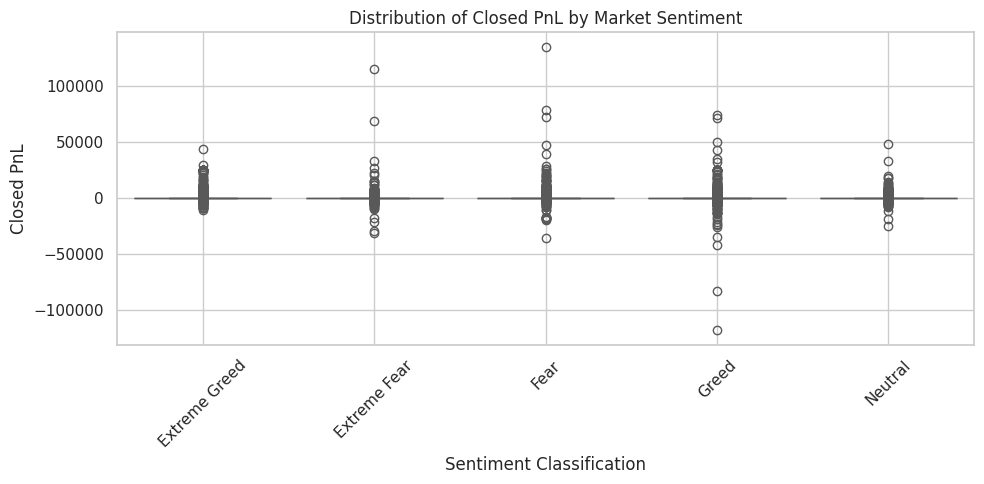

In [79]:
# STEP 8: Visualize PnL Distribution by Market Sentiment

plt.figure(figsize=(10, 5))
sns.boxplot(data=merged_df, x='classification', y='Closed PnL', palette="Set2")
plt.title("Distribution of Closed PnL by Market Sentiment")
plt.ylabel("Closed PnL")
plt.xlabel("Sentiment Classification")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/ds_ankurjat/outputs/pnl_boxplot.png")
plt.show()


### PnL Distribution Insights (Boxplot)

- **All sentiments show wide variability in profits**, with a significant number of outliers (both large gains and losses).
- The **median PnL** is close to zero across all categories, but **Extreme Greed and Fear** show wider spread — indicating **higher volatility**.
- **Extreme Greed** has fewer negative outliers, suggesting **less downside risk** during bullish markets.

This suggests that while greed-driven markets can produce high rewards, they are slightly more consistent than fear-driven markets, which have more erratic outcomes.


## Step 10: Trade Direction Analysis (BUY vs SELL)

To uncover behavioral trends, we analyze how the proportion of BUY and SELL trades varies across sentiment types.

This helps answer:
- Are traders more likely to **sell in fear** (panic)?
- Do they **buy aggressively in greed** (optimism)?

Visualizing this gives insight into market confidence under different sentiment conditions.


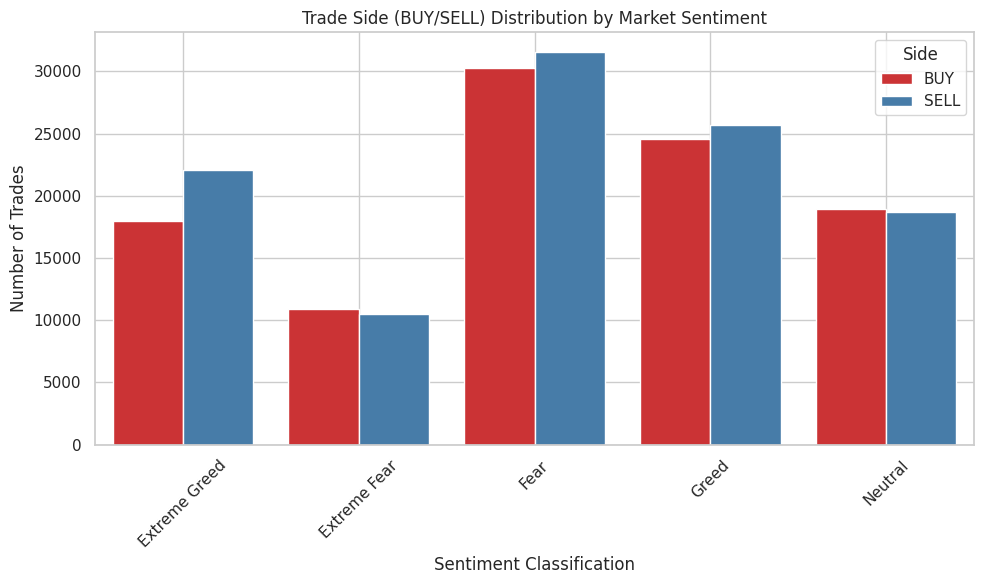

In [80]:
# STEP 9: Countplot of trade side (BUY/SELL) across sentiment

plt.figure(figsize=(10, 6))
sns.countplot(data=merged_df, x='classification', hue='Side', palette='Set1')
plt.title("Trade Side (BUY/SELL) Distribution by Market Sentiment")
plt.xlabel("Sentiment Classification")
plt.ylabel("Number of Trades")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/ds_ankurjat/outputs/trade_direction_by_sentiment.png")
plt.show()


### Trade Direction Insights by Sentiment (BUY vs SELL)

- **Fear and Greed** both show a high number of trades, with slightly more SELLs than BUYs — indicating cautious or profit-taking behavior.
- In **Extreme Greed**, traders tend to BUY more, likely driven by FOMO (fear of missing out).
- In **Extreme Fear**, BUY and SELL volumes are nearly equal, showing uncertainty or indecision.
- **Neutral** sentiment sees balanced BUY/SELL behavior, as expected.

These insights suggest that traders are more likely to **sell in high fear**, but also **buy aggressively in extreme greed**, confirming sentiment-driven trading behaviors.


## Final Insights & Strategic Takeaways

After analyzing over 211,000 trades aligned with daily market sentiment, the following key insights were identified:

### Profitability Trends
- Extreme Greed produced the highest average Closed PnL, suggesting that traders benefit most during bullish, high-confidence periods.
- Fear and Extreme Fear had more volatile and less profitable outcomes, indicating the need for tighter risk control.

### Trading Volume and Activity
- Fear sentiment triggered the highest trading volume and average fees, implying increased (possibly panic-driven) activity and risk.
- This presents opportunities for high-volume strategies, but also demands strong cost and risk management.

### Trader Behavior (BUY vs SELL)
- Traders tend to sell more during Fear and Greed, likely to secure profits or reduce risk.
- Conversely, BUY trades dominate during Extreme Greed, hinting at optimism-driven buying behavior.

### Profit Distribution Patterns
- Profits across all sentiments show high variance and many outliers.
- Extreme Greed showed more consistent positive trades, while Fear and Extreme Fear had more frequent losses.

---

### Strategic Applications

These behavioral signals can be used to:
- Build sentiment-aware trading strategies
- Adjust position sizing based on fear or greed intensity
- Time entries during fear spikes and exits during greed
- Incorporate direction bias (buy/sell) based on sentiment

By combining sentiment and trade data, smarter, more adaptive models can be developed that respond dynamically to market emotions.
